In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
from torchsummary import summary
import torch.nn.functional as F


In [2]:
## File input/output related attributes
## Hint: you might need to modify these variables for supporting your os system
training_dataroot = "df.csv"                 # Training data file name
model_save_root = "./model"                     # Root directory name for saving your models
test_prediction_csv_output_path = "prediction.csv"    # Testing prediction csv file name

# create the model saving root if not exists
# Hint: if you encountering issues like os error, you can comment the following 2 lines of code and create the folder for saving your model manually
if not os.path.exists(model_save_root):
    os.makedirs(model_save_root)


## Model training related attributes
## TODO: try to modify the hyperparameters for better model performance
use_gpu = True       # whether use GPU when training model (*note that it will be ignored if there's no supported GPU in your machine and use CPU instead)
BATCH_SIZE = 2048       # number of batch size when training model
NUM_EPOCHS = 200      # number of epochs when training model
LEARNING_RATE = 0.00005  # learning rate of the optimizer
WINDOW_SIZE = 30
WEIGHT_DECAY = 5e-3
DROPOUT_RATE = 0.4
USE_BATCHNORM = True
TEST_SIZE = 0.2
#0.01 #0.005 #0.001 #0.0005 #0.00001 #0.000005
#(256, 200, 0.00005, 30, 1e-4, 0.35, True)

In [3]:
df_train_origin = pd.read_csv(training_dataroot)
df_train_origin['Date'] = pd.to_datetime(df_train_origin['Date'])
df_train_origin = df_train_origin.sort_values('Date').reset_index(drop=True)
display(df_train_origin.head(5))
print("Number of training data: {}".format(len(df_train_origin)))
print("Total data points:", len(df_train_origin))


,Date,Capacity,Turnover,Open,High,Low,Close,Change,Transaction,MA5,...,BB_position,DJI,NASDAQ,SOX,SPX,ADR,tw,TWD,rate,Movement
0,2010-01-04,39511138,2557720928,65.0,65.0,64.0,64.9,0.4,8255,64.5,...,0.325045,0.00,-0.97,-0.42,-1.00,1.42,0.040000,0.958466,0.000000,0
1,2010-01-05,38394084,2464115096,65.0,65.1,63.9,64.5,-0.4,9205,64.5,...,0.325045,1.50,1.73,1.72,1.61,1.22,0.043251,-0.634921,-0.616333,0
2,2010-01-06,52734385,3390698544,64.5,64.9,63.7,64.9,0.4,12597,64.5,...,0.325045,-0.11,0.01,0.08,0.31,-0.43,1.415349,0.000000,0.620155,1
3,2010-01-07,53294614,3437221996,64.9,65.0,64.2,64.2,-0.7,11195,64.5,...,0.325045,0.02,-0.33,-0.03,0.05,-0.35,-1.083143,0.000000,-1.078582,0
4,2010-01-08,48047497,3068341466,63.5,64.3,63.5,64.0,-0.2,9804,64.5,...,0.325045,0.31,-0.05,-1.09,0.40,-3.31,0.527835,0.000000,-0.311526,0


Number of training data: 3887
Total data points: 3887


In [4]:
# 1. 針對外部市場指標計算漲跌幅 (Rate)
external_indices = ['DJI', 'NASDAQ', 'SOX', 'SPX', 'tw', 'TWD']

for col in external_indices:
    # 建立新欄位名稱
    rate_col = f'{col}_rate'

    # 計算漲跌幅
    df_train_origin[rate_col] = df_train_origin[col].pct_change()

    # --- 關鍵修正開始 ---

    # 步驟 1: 將無限大 (inf, -inf) 替換為 NaN
    df_train_origin[rate_col].replace([np.inf, -np.inf], np.nan, inplace=True)

    # 步驟 2: 填補 NaN 值
    # 第一筆資料因為沒有前一天，pct_change 會是 NaN，通常補 0 (代表無變化)
    # 或是之前產生 inf 的地方也補 0
    df_train_origin[rate_col] = df_train_origin[rate_col].fillna(0)

    # --- 關鍵修正結束 ---

print("Feature Names = {}".format([c for c in df_train_origin.columns.values]))

Feature Names = ['Date', 'Capacity', 'Turnover', 'Open', 'High', 'Low', 'Close', 'Change', 'Transaction', 'MA5', 'MA10', 'MA5_Capacity', 'BR5', 'BR10', 'High-Low', 'Open-Close', 'EMA5', 'EMA10', 'K', 'D', 'MACD', 'MACD_signal', 'MACD_hist', 'RSI14', 'STD20', 'ADX', 'ATR', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_position', 'DJI', 'NASDAQ', 'SOX', 'SPX', 'ADR', 'tw', 'TWD', 'rate', 'Movement', 'DJI_rate', 'NASDAQ_rate', 'SOX_rate', 'SPX_rate', 'tw_rate', 'TWD_rate']


/tmp/ipython-input-3495745994.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train_origin[rate_col].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipython-input-3495745994.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(v

In [5]:
## data processing
all_column =  ['Date', 'Capacity', 'Turnover', 'Open', 'High', 'Low', 'Close', 'Change', 'Transaction', 'MA5', 'MA10', 'MA5_Capacity',
               'BR5', 'BR10', 'High-Low', 'Open-Close', 'EMA5', 'EMA10', 'K', 'D', 'MACD', 'MACD_signal', 'MACD_hist',
               'RSI14', 'STD20', 'ADX', 'ATR', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_position', 'DJI', 'NASDAQ', 'SOX', 'SPX', 'ADR', 'tw', 'TWD', 'rate', 'Movement',
               'DJI_rate', 'NASDAQ_rate', 'SOX_rate', 'SPX_rate', 'tw_rate', 'TWD_rate']

# drop_column = ['Change', 'Transaction', 'Turnover', 'MA5_Capacity', 'BR5', 'BR10','MA5', 'MA10', 'High-Low', 'Open-Close', 'STD20', 'ADX', 'tw', 'rate', 'DJI',
#                'TWD', 'DJI_rate', 'NASDAQ_rate', 'SOX_rate', 'SPX_rate', 'tw_rate', 'TWD_rate', 'ATR', 'BB_Lower', 'BB_Middle', 'BB_Upper', 'BB_position']
drop_column = ['Capacity', 'Turnover', 'Open', 'High', 'Low' , 'Transaction', 'MA5', 'MA10', 'EMA5', 'EMA10', 'MA5_Capacity', 'tw', 'BB_Middle', 'BB_Upper', 'BB_Lower',
               'NASDAQ', 'SOX', 'SPX', 'ADR', 'tw', 'TWD', 'DJI']
# drop_column = [
#     # 1. 格式與作弊欄位
#     'Movement',

#     # 2. 絕對價格與成交量 (過擬合元兇) Do not delete close
#     'Open', 'High', 'Low',
#     'tw',
#     'Capacity', 'Turnover', 'Transaction', 'MA5_Capacity',

#     # 3. 絕對均線 (已有 MACD 替代，且均線是價格的延遲)
#     'MA5', 'MA10', 'EMA5', 'EMA10',

#     # 4. (選用) 如果 RSI 與 RSI14 重複，可移除一個
#       'BB_Upper', 'BB_Lower',
#     # 新增：把原始的外部指標絕對值也刪掉
#     'DJI', 'NASDAQ', 'SOX', 'SPX', 'ADR'
# ]
#Capacity	Open	High	Low	Close	EMA5	EMA10	K	D	MACD	MACD_signal	MACD_hist	RSI14	RSI	NASDAQ	SOX	SPX	ADR	twclose

# 刪除 'Date' 欄位
df_modified = df_train_origin.drop(columns=drop_column)

# 刪除前 33 個 row（保留從第 33 行開始的資料，Pandas 索引從 0 開始，因此使用 iloc[32:]）
#df_modified = df_modified.iloc[33:]

# 重置索引（可選，但建議使用以確保索引連續）
df_modified = df_modified.reset_index(drop=True)

df = df_modified

display(df.head(5))
print("Number of training data: {}".format(len(df)))

,Date,Close,Change,BR5,BR10,High-Low,Open-Close,K,D,MACD,...,ATR,BB_position,rate,Movement,DJI_rate,NASDAQ_rate,SOX_rate,SPX_rate,tw_rate,TWD_rate
0,2010-01-04,64.9,0.4,-0.775194,-0.796751,1.0,0.1,9.305437,5.383565,-2.095676,...,0.992857,0.325045,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2010-01-05,64.5,-0.4,-0.775194,-0.796751,1.2,0.5,9.305437,5.383565,-2.095676,...,0.992857,0.325045,-0.616333,0,0.000000,-2.783505,-5.095238,-2.610000,0.081282,-1.662434
2,2010-01-06,64.9,0.4,-0.775194,-0.796751,1.2,-0.4,9.305437,5.383565,-2.095676,...,0.992857,0.325045,0.620155,1,-1.073333,-0.994220,-0.953488,-0.807453,31.723874,-1.000000
3,2010-01-07,64.2,-0.7,-0.775194,-0.796751,0.8,0.7,9.305437,5.383565,-2.095676,...,0.992857,0.325045,-1.078582,0,-1.181818,-34.000000,-1.375000,-0.838710,-1.765283,0.000000
4,2010-01-08,64.0,-0.2,-0.775194,-0.796751,0.8,-0.5,9.305437,5.383565,-2.095676,...,0.992857,0.325045,-0.311526,0,14.500000,-0.848485,35.333333,7.000000,-1.487318,0.000000


Number of training data: 3887


In [6]:
## data labeling
features = []     # 臨時儲存輸入特徵的列表
labels = []       # 臨時儲存輸出標籤的列表
dates = []        # 儲存目標日期，用於後續分割

# 設定預測天數
PREDICT_DAYS = 5

# 移除 Date 和 Target 欄位，保留其他作為特徵
target_column = 'Movement'
drop_cols = ['Date', target_column]
feature_columns = [c for c in df.columns if c not in drop_cols]
print(f"Single day feature count: {len(feature_columns)}")
print(f"Features: {feature_columns}")

# 注意迴圈範圍需減去 PREDICT_DAYS，確保有足夠的未來資料
for i in range(WINDOW_SIZE, len(df) - PREDICT_DAYS):
    # 1. 取得過去 30 天的特徵 (不包含 Date 和 Label)
    # 這裡的 window 是 [i-WINDOW_SIZE, i-1]
    feat_data = df.iloc[i-WINDOW_SIZE:i][feature_columns].values.flatten()
    features.append(feat_data)

    # 2. 製作 T+5 的標籤
    # 邏輯：比較「5天後的收盤價」與「最近一天(視窗最後一天 i-1)的收盤價」
    # df.iloc[i] 是 T+1 (第一天預測日)，所以 df.iloc[i + 4] 是 T+5
    current_close = df.iloc[i - 1]['Close']
    future_close = df.iloc[i + PREDICT_DAYS - 1]['Close']

    label = 1 if future_close > current_close else 0
    labels.append(label)

    # 3. 紀錄日期 (這裡紀錄的是預測目標當天的日期)
    target_date = df.iloc[i + PREDICT_DAYS - 1]['Date']
    dates.append(target_date)

    # 用於除錯：印出前幾筆的價格比較
    if i <= WINDOW_SIZE + 3:
        print(f"Index: {i}, Current(T): {current_close}, Future(T+{PREDICT_DAYS}): {future_close}, Label: {label}, Date: {target_date}")

print("Feature Names = {}".format([c for c in feature_columns]))

# 轉為 DataFrame 以便處理
# 欄位命名：day_1 到 day_30 代表過去30天的數據
cols = [f'day_{d+1}_{col}' for d in range(WINDOW_SIZE) for col in feature_columns]
df_features = pd.DataFrame(features, columns=cols)
df_features['label'] = labels
df_features['Date'] = dates

print(f"Total processed samples: {len(df_features)}")
print(f"Input Feature Dimension: {len(cols)}")

# 檢查一下欄位名稱範例
print("Column names example:", cols[:5])

df_features.to_csv('processed_data_5days.csv')
display(df_features.head(5))
print("Number of training data: {}".format(len(df_features)))

Single day feature count: 23
Features: ['Close', 'Change', 'BR5', 'BR10', 'High-Low', 'Open-Close', 'K', 'D', 'MACD', 'MACD_signal', 'MACD_hist', 'RSI14', 'STD20', 'ADX', 'ATR', 'BB_position', 'rate', 'DJI_rate', 'NASDAQ_rate', 'SOX_rate', 'SPX_rate', 'tw_rate', 'TWD_rate']
Index: 30, Current(T): 59.0, Future(T+5): 59.6, Label: 1, Date: 2010-03-01 00:00:00
Index: 31, Current(T): 59.8, Future(T+5): 59.9, Label: 1, Date: 2010-03-02 00:00:00
Index: 32, Current(T): 58.5, Future(T+5): 60.0, Label: 1, Date: 2010-03-03 00:00:00
Index: 33, Current(T): 58.2, Future(T+5): 59.2, Label: 1, Date: 2010-03-04 00:00:00
Feature Names = ['Close', 'Change', 'BR5', 'BR10', 'High-Low', 'Open-Close', 'K', 'D', 'MACD', 'MACD_signal', 'MACD_hist', 'RSI14', 'STD20', 'ADX', 'ATR', 'BB_position', 'rate', 'DJI_rate', 'NASDAQ_rate', 'SOX_rate', 'SPX_rate', 'tw_rate', 'TWD_rate']
Total processed samples: 3852
Input Feature Dimension: 690
Column names example: ['day_1_Close', 'day_1_Change', 'day_1_BR5', 'day_1_BR10

,day_1_Close,day_1_Change,day_1_BR5,day_1_BR10,day_1_High-Low,day_1_Open-Close,day_1_K,day_1_D,day_1_MACD,day_1_MACD_signal,...,day_30_BB_position,day_30_rate,day_30_DJI_rate,day_30_NASDAQ_rate,day_30_SOX_rate,day_30_SPX_rate,day_30_tw_rate,day_30_TWD_rate,label,Date
0,64.9,0.4,-0.775194,-0.796751,1.0,0.1,9.305437,5.383565,-2.095676,-1.786677,...,0.359574,1.027397,-1.000000,-0.914530,-0.794326,-0.832061,0.446988,0.0,1,2010-03-01
1,64.5,-0.4,-0.775194,-0.796751,1.2,0.5,9.305437,5.383565,-2.095676,-1.786677,...,0.493158,1.355932,0.000000,-1.800000,-1.896552,-1.500000,-0.688534,0.0,1,2010-03-02
2,64.9,0.4,-0.775194,-0.796751,1.2,-0.4,9.305437,5.383565,-2.095676,-1.786677,...,0.314676,-2.173913,4.388889,15.000000,9.884615,10.000000,-2.803112,0.0,1,2010-03-03
3,64.2,-0.7,-0.775194,-0.796751,0.8,0.7,9.305437,5.383565,-2.095676,-1.786677,...,0.278073,-0.512821,-1.917526,-1.789062,-1.678445,-1.801653,0.529208,-1.0,1,2010-03-04
4,64.0,-0.2,-0.775194,-0.796751,0.8,-0.5,9.305437,5.383565,-2.095676,-1.786677,...,0.408533,1.030928,-1.573034,-1.079208,-1.140625,-1.216495,-1.090219,0.0,1,2010-03-05


Number of training data: 3852


In [7]:


df_processed = df_features
train_data = df_processed[(df_processed['Date'].dt.year >= 2010) & (df_processed['Date'].dt.year <= 2024)]


df_train, df_valid = train_test_split(
    train_data,
    test_size=TEST_SIZE,  # 驗證集佔 20%，確保 >=300 筆（如果訓練數據 1500 筆，則驗證集 300 筆）
    #random_state=0,  # 固定隨機種子
    stratify=train_data['label']  # 按標籤分層抽樣，確保類別平衡
)

# df_train = train_data[train_data['Date'].dt.year < 2019]
# df_valid = train_data[train_data['Date'].dt.year == 2019]
df_test = df_processed[df_processed['Date'].dt.year == 2025]

print(f"Train set (2010-2018): {len(df_train)} samples")
print(f"Valid set (2019): {len(df_valid)} samples")
print(f"Test set (2020): {len(df_test)} samples")

Train set (2010-2018): 2917 samples
Valid set (2019): 730 samples
Test set (2020): 205 samples


In [8]:
# reset index of df_train and df_valid
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
#if don't reset, index of data will be mess

In [9]:
# show df_train, df_valid, df_test
display(df_train.head(5))
display(df_valid.head(5))
display(df_test.head(5))


print("Feature Names = {}".format([c for c in df_train.columns.values]))
print()
print("(Number of cases, Number of features) -> ")
print("Train: {}".format(df_train.shape))
print("Valid: {}".format(df_valid.shape))
print("Valid: {}".format(df_test.shape))


,day_1_Close,day_1_Change,day_1_BR5,day_1_BR10,day_1_High-Low,day_1_Open-Close,day_1_K,day_1_D,day_1_MACD,day_1_MACD_signal,...,day_30_BB_position,day_30_rate,day_30_DJI_rate,day_30_NASDAQ_rate,day_30_SOX_rate,day_30_SPX_rate,day_30_tw_rate,day_30_TWD_rate,label,Date
0,586.0,5.0,2.268761,2.268761,6.0,-3.0,51.993007,34.534285,-14.226452,-15.324457,...,0.166370,0.564972,-0.230769,-0.865031,-0.786325,-0.157895,-1.721574,7.489965,0,2022-05-11
1,125.0,0.0,-1.029295,-1.029295,1.0,1.0,43.333333,58.148148,0.523072,0.495042,...,0.909787,-1.162791,-1.702290,-1.345833,-1.379501,-1.372449,-1.186525,0.000000,1,2014-10-30
2,960.0,15.0,0.083403,1.244463,9.0,-9.0,73.812720,79.507869,33.931793,31.804334,...,0.249245,-2.608696,-1.789474,-2.019417,-3.915094,-1.740385,-1.515350,1.740114,1,2024-08-15
3,259.0,9.5,4.309303,6.038895,5.5,-5.5,88.611111,75.185185,3.722461,3.014737,...,-0.290291,-6.762295,-22.000000,5.089552,2.991071,81.000000,-61.553388,0.000000,1,2018-10-18
4,422.0,-13.0,2.977062,8.025086,12.0,6.0,79.239023,85.656294,25.466598,19.444099,...,0.518052,1.173709,0.000000,0.000000,0.000000,0.000000,-2.705617,0.000000,1,2020-09-15


,day_1_Close,day_1_Change,day_1_BR5,day_1_BR10,day_1_High-Low,day_1_Open-Close,day_1_K,day_1_D,day_1_MACD,day_1_MACD_signal,...,day_30_BB_position,day_30_rate,day_30_DJI_rate,day_30_NASDAQ_rate,day_30_SOX_rate,day_30_SPX_rate,day_30_tw_rate,day_30_TWD_rate,label,Date
0,144.0,-1.5,-2.571042,-3.646705,1.0,1.0,35.897436,50.427350,1.673026,2.450672,...,0.357729,0.701754,-1.401709,-0.692913,-0.235955,-1.163043,-5.195888,0.000000,1,2015-04-29
1,59.5,0.3,-1.228420,-0.800267,0.6,0.1,30.799756,38.614164,-0.575932,-0.436531,...,0.509092,-1.134522,0.000000,-1.481481,-20.000000,-1.689655,-3.950595,-2.000000,0,2010-07-06
2,70.7,0.9,1.931949,0.798403,1.0,0.0,30.666667,16.009768,-0.283935,-0.198458,...,0.852455,-0.779221,-3.155340,-2.700730,-3.020000,-3.150943,-1.957885,-0.501429,0,2011-06-10
3,381.5,-2.5,1.381876,3.993458,4.0,0.5,93.081407,93.702320,17.469845,14.425975,...,0.571493,-0.459770,-1.974359,1.044118,-13.250000,-4.409091,-1.033504,-0.000294,0,2020-09-09
4,309.5,-6.5,-2.519685,-0.817177,9.0,6.5,68.696619,81.571465,6.035851,4.693086,...,1.092133,2.473498,-1.632353,-2.776596,-3.070513,-2.193548,-1.005398,-1.132668,0,2020-08-04


,day_1_Close,day_1_Change,day_1_BR5,day_1_BR10,day_1_High-Low,day_1_Open-Close,day_1_K,day_1_D,day_1_MACD,day_1_MACD_signal,...,day_30_BB_position,day_30_rate,day_30_DJI_rate,day_30_NASDAQ_rate,day_30_SOX_rate,day_30_SPX_rate,day_30_tw_rate,day_30_TWD_rate,label,Date
0,1035.0,0.0,-2.266289,-1.756051,15.0,-5.0,46.808511,64.568856,10.706173,15.789317,...,0.743248,0.462963,4.68750,0.377551,-0.654839,0.506849,5.358100,3.500000,0,2025-01-02
1,1035.0,0.0,-1.240458,-1.849218,15.0,5.0,41.489362,50.945626,8.570352,14.345524,...,0.731723,0.000000,-1.00000,0.000000,0.000000,0.000000,-0.732759,-0.109071,0,2025-01-03
2,1025.0,-10.0,-1.061776,-2.659069,15.0,5.0,37.943262,42.080378,6.001600,12.676740,...,0.822665,0.460829,0.00000,-1.037037,-0.971963,-1.036364,0.070752,-0.125000,1,2025-01-06
3,1040.0,15.0,0.580271,-1.140684,20.0,-10.0,39.716312,39.716312,5.117232,11.164838,...,0.808203,0.000000,-12.00000,28.800000,-34.666667,26.750000,-3.970579,-1.572367,1,2025-01-07
4,1025.0,-15.0,-0.678295,-2.241297,30.0,20.0,36.170213,37.943262,3.169453,9.565761,...,0.539394,-1.376147,0.25974,-0.201342,0.861386,-0.036036,0.821148,-2.745986,1,2025-01-08


Feature Names = ['day_1_Close', 'day_1_Change', 'day_1_BR5', 'day_1_BR10', 'day_1_High-Low', 'day_1_Open-Close', 'day_1_K', 'day_1_D', 'day_1_MACD', 'day_1_MACD_signal', 'day_1_MACD_hist', 'day_1_RSI14', 'day_1_STD20', 'day_1_ADX', 'day_1_ATR', 'day_1_BB_position', 'day_1_rate', 'day_1_DJI_rate', 'day_1_NASDAQ_rate', 'day_1_SOX_rate', 'day_1_SPX_rate', 'day_1_tw_rate', 'day_1_TWD_rate', 'day_2_Close', 'day_2_Change', 'day_2_BR5', 'day_2_BR10', 'day_2_High-Low', 'day_2_Open-Close', 'day_2_K', 'day_2_D', 'day_2_MACD', 'day_2_MACD_signal', 'day_2_MACD_hist', 'day_2_RSI14', 'day_2_STD20', 'day_2_ADX', 'day_2_ATR', 'day_2_BB_position', 'day_2_rate', 'day_2_DJI_rate', 'day_2_NASDAQ_rate', 'day_2_SOX_rate', 'day_2_SPX_rate', 'day_2_tw_rate', 'day_2_TWD_rate', 'day_3_Close', 'day_3_Change', 'day_3_BR5', 'day_3_BR10', 'day_3_High-Low', 'day_3_Open-Close', 'day_3_K', 'day_3_D', 'day_3_MACD', 'day_3_MACD_signal', 'day_3_MACD_hist', 'day_3_RSI14', 'day_3_STD20', 'day_3_ADX', 'day_3_ATR', 'day_3_BB

In [10]:
# names of numerical features
#numerical_feature_column_names = [c for c in df_processed.columns if c not in ['label', 'Date']]
print(cols)
numerical_feature_column_names = cols

# show numerical features before preprocessing
numerical_train = df_train[numerical_feature_column_names]
numerical_valid = df_valid[numerical_feature_column_names]
numerical_test = df_test[numerical_feature_column_names]

print(
    "Before min-max scaling: \n" \
    "min = {} \n" \
    "max = {} \n".format(
        np.min(numerical_train.values, axis=0), np.max(numerical_train.values, axis=0),
    )
)

# create scaler and preprocess numerical features with it
## TODO:
min_max_scaler = MinMaxScaler()
scaled_train = min_max_scaler.fit_transform(numerical_train)
scaled_valid = min_max_scaler.transform(numerical_valid)
scaled_test = min_max_scaler.transform(numerical_test)

print(
    "After min-max scaling: \n" \
    "min = {} \n" \
    "max = {} \n".format(
        np.min(scaled_train, axis=0), np.max(scaled_train, axis=0),
    )
)


['day_1_Close', 'day_1_Change', 'day_1_BR5', 'day_1_BR10', 'day_1_High-Low', 'day_1_Open-Close', 'day_1_K', 'day_1_D', 'day_1_MACD', 'day_1_MACD_signal', 'day_1_MACD_hist', 'day_1_RSI14', 'day_1_STD20', 'day_1_ADX', 'day_1_ATR', 'day_1_BB_position', 'day_1_rate', 'day_1_DJI_rate', 'day_1_NASDAQ_rate', 'day_1_SOX_rate', 'day_1_SPX_rate', 'day_1_tw_rate', 'day_1_TWD_rate', 'day_2_Close', 'day_2_Change', 'day_2_BR5', 'day_2_BR10', 'day_2_High-Low', 'day_2_Open-Close', 'day_2_K', 'day_2_D', 'day_2_MACD', 'day_2_MACD_signal', 'day_2_MACD_hist', 'day_2_RSI14', 'day_2_STD20', 'day_2_ADX', 'day_2_ATR', 'day_2_BB_position', 'day_2_rate', 'day_2_DJI_rate', 'day_2_NASDAQ_rate', 'day_2_SOX_rate', 'day_2_SPX_rate', 'day_2_tw_rate', 'day_2_TWD_rate', 'day_3_Close', 'day_3_Change', 'day_3_BR5', 'day_3_BR10', 'day_3_High-Low', 'day_3_Open-Close', 'day_3_K', 'day_3_D', 'day_3_MACD', 'day_3_MACD_signal', 'day_3_MACD_hist', 'day_3_RSI14', 'day_3_STD20', 'day_3_ADX', 'day_3_ATR', 'day_3_BB_position', 'day

In [11]:
# create new dataframe with processed numerical features: scaled_train, scaled_valid, scaled_test
df_scaled_train = pd.DataFrame(
    data=scaled_train,
    columns=min_max_scaler.get_feature_names_out(),
)
df_scaled_valid = pd.DataFrame(
    data=scaled_valid,
    columns=min_max_scaler.get_feature_names_out(),
)


In [12]:
# create new dataframe with processed numerical features: scaled_train, scaled_valid, scaled_test
df_scaled_train = pd.DataFrame(
    data=scaled_train,
    columns=min_max_scaler.get_feature_names_out(),
)
df_scaled_valid = pd.DataFrame(
    data=scaled_valid,
    columns=min_max_scaler.get_feature_names_out(),
)
df_scaled_test = pd.DataFrame(
    data=scaled_test,
    columns=min_max_scaler.get_feature_names_out(),
)



In [13]:



# name of label feature
label_column_name = [
    "label",
]

# extract the labels of all subjects
## TODO:
df_label_train = df_train[label_column_name]
df_label_valid = df_valid[label_column_name]


# show number of classes and the valid values of the label
class_idxs = np.unique(df_label_train[label_column_name].values)
num_classes = len(class_idxs)
print("class_idxs = {}".format(class_idxs))
print("num classes = {}".format(num_classes))

class_idxs = [0 1]
num classes = 2


In [14]:
# show df_label_train, df_label_valid
display(df_label_train.head(5))
display(df_label_valid.head(5))

print("Label Names = {}".format(df_label_train.columns.values))
print()
print("(Number of cases, Number of features) -> ")
print("Train: {}".format(df_label_train.shape))
print("Valid: {}".format(df_label_valid.shape))

,label
0,0
1,1
2,1
3,1
4,1


,label
0,1
1,0
2,0
3,0
4,0


Label Names = ['label']

(Number of cases, Number of features) -> 
Train: (2917, 1)
Valid: (730, 1)


In [15]:
# concatenate dataframes of processed numerical features, processed categorical features and extracted label
df_preprocess_train = pd.concat(
    [df_scaled_train, df_label_train],
    axis=1,
)
df_preprocess_valid = pd.concat(
    [df_scaled_valid, df_label_valid],
    axis=1,
)

df_preprocess_test = pd.concat(
    [df_scaled_test],
    axis=1,
)


In [16]:
# show df_preprocess_train, df_preprocess_valid, df_preprocess_test
display(df_preprocess_train.head(5))
display(df_preprocess_valid.head(5))
display(df_preprocess_test.head(5))

print("Feature Names = {}".format([c for c in df_preprocess_train.columns.values]))

print()
print("(Number of cases, Number of features) -> ")
print("Train: {}".format(df_preprocess_train.shape))
print("Valid: {}".format(df_preprocess_valid.shape))


,day_1_Close,day_1_Change,day_1_BR5,day_1_BR10,day_1_High-Low,day_1_Open-Close,day_1_K,day_1_D,day_1_MACD,day_1_MACD_signal,...,day_30_ATR,day_30_BB_position,day_30_rate,day_30_DJI_rate,day_30_NASDAQ_rate,day_30_SOX_rate,day_30_SPX_rate,day_30_tw_rate,day_30_TWD_rate,label
0,0.512006,0.574074,0.576671,0.535595,0.109848,0.483871,0.519930,0.337856,0.118665,0.087547,...,0.211356,0.265139,0.486049,0.467572,0.289771,0.564934,0.477060,0.736792,0.815095,0
1,0.065647,0.527778,0.384634,0.423349,0.015152,0.548387,0.433333,0.580438,0.342124,0.350335,...,0.055288,0.696770,0.391674,0.463965,0.289010,0.563680,0.474175,0.737147,0.652057,1
2,0.874129,0.666667,0.449423,0.500734,0.166667,0.387097,0.738127,0.799864,0.848275,0.870435,...,0.996679,0.313257,0.312695,0.463751,0.287944,0.558319,0.473301,0.736929,0.689935,1
3,0.195391,0.615741,0.695487,0.663908,0.100379,0.443548,0.886111,0.755457,0.390596,0.392191,...,0.111738,0.000000,0.085814,0.414216,0.299192,0.572920,0.669834,0.697074,0.652057,1
4,0.353215,0.407407,0.617914,0.731507,0.223485,0.629032,0.792390,0.863026,0.720025,0.665111,...,0.235431,0.469327,0.519300,0.468137,0.291139,0.566596,0.477435,0.736139,0.652057,1


,day_1_Close,day_1_Change,day_1_BR5,day_1_BR10,day_1_High-Low,day_1_Open-Close,day_1_K,day_1_D,day_1_MACD,day_1_MACD_signal,...,day_30_ATR,day_30_BB_position,day_30_rate,day_30_DJI_rate,day_30_NASDAQ_rate,day_30_SOX_rate,day_30_SPX_rate,day_30_tw_rate,day_30_TWD_rate,label
0,0.084043,0.513889,0.294862,0.334268,0.015152,0.548387,0.358974,0.501123,0.359546,0.382821,...,0.054458,0.376243,0.493520,0.464702,0.290043,0.566097,0.474672,0.734486,0.652057,1
1,0.002227,0.530556,0.373039,0.431144,0.007576,0.533871,0.307998,0.379768,0.325474,0.334860,...,0.006475,0.464125,0.393218,0.468137,0.288795,0.524313,0.473421,0.735313,0.608522,0
2,0.013071,0.536111,0.557060,0.485553,0.015152,0.532258,0.306667,0.147556,0.329898,0.338815,...,0.012784,0.663483,0.412626,0.460404,0.286866,0.560211,0.469950,0.736635,0.641142,0
3,0.314001,0.504630,0.525030,0.594294,0.071970,0.540323,0.930814,0.945681,0.598872,0.581751,...,0.240412,0.500355,0.430075,0.463298,0.292791,0.538584,0.466962,0.737249,0.652051,0
4,0.244287,0.467593,0.297852,0.430568,0.166667,0.637097,0.686966,0.821063,0.425644,0.420072,...,0.307654,0.802641,0.590298,0.464136,0.286746,0.560105,0.472224,0.737268,0.627402,0


,day_1_Close,day_1_Change,day_1_BR5,day_1_BR10,day_1_High-Low,day_1_Open-Close,day_1_K,day_1_D,day_1_MACD,day_1_MACD_signal,...,day_30_ADX,day_30_ATR,day_30_BB_position,day_30_rate,day_30_DJI_rate,day_30_NASDAQ_rate,day_30_SOX_rate,day_30_SPX_rate,day_30_tw_rate,day_30_TWD_rate
0,0.946747,0.527778,0.312607,0.398614,0.280303,0.451613,0.468085,0.646397,0.496401,0.604399,...,0.116950,0.475345,0.600076,0.480477,0.479626,0.291737,0.565212,0.478639,0.741492,0.728243
1,0.946747,0.527778,0.372338,0.395443,0.280303,0.612903,0.414894,0.506448,0.464042,0.580415,...,0.119061,0.450440,0.593385,0.455189,0.465686,0.291139,0.566596,0.477435,0.737449,0.649683
2,0.937064,0.435185,0.382743,0.367881,0.280303,0.612903,0.379433,0.415376,0.425125,0.552694,...,0.121021,0.458741,0.646187,0.480360,0.468137,0.289498,0.564541,0.474973,0.737982,0.649336
3,0.951588,0.666667,0.478355,0.419558,0.375000,0.370968,0.397163,0.391090,0.411727,0.527578,...,0.122841,0.450440,0.637790,0.455189,0.438725,0.336709,0.493305,0.540974,0.735299,0.617831
4,0.937064,0.388889,0.405072,0.382099,0.564394,0.854839,0.361702,0.372876,0.382217,0.501015,...,0.112817,0.442138,0.481718,0.380020,0.468774,0.290821,0.568417,0.477349,0.738480,0.592284


Feature Names = ['day_1_Close', 'day_1_Change', 'day_1_BR5', 'day_1_BR10', 'day_1_High-Low', 'day_1_Open-Close', 'day_1_K', 'day_1_D', 'day_1_MACD', 'day_1_MACD_signal', 'day_1_MACD_hist', 'day_1_RSI14', 'day_1_STD20', 'day_1_ADX', 'day_1_ATR', 'day_1_BB_position', 'day_1_rate', 'day_1_DJI_rate', 'day_1_NASDAQ_rate', 'day_1_SOX_rate', 'day_1_SPX_rate', 'day_1_tw_rate', 'day_1_TWD_rate', 'day_2_Close', 'day_2_Change', 'day_2_BR5', 'day_2_BR10', 'day_2_High-Low', 'day_2_Open-Close', 'day_2_K', 'day_2_D', 'day_2_MACD', 'day_2_MACD_signal', 'day_2_MACD_hist', 'day_2_RSI14', 'day_2_STD20', 'day_2_ADX', 'day_2_ATR', 'day_2_BB_position', 'day_2_rate', 'day_2_DJI_rate', 'day_2_NASDAQ_rate', 'day_2_SOX_rate', 'day_2_SPX_rate', 'day_2_tw_rate', 'day_2_TWD_rate', 'day_3_Close', 'day_3_Change', 'day_3_BR5', 'day_3_BR10', 'day_3_High-Low', 'day_3_Open-Close', 'day_3_K', 'day_3_D', 'day_3_MACD', 'day_3_MACD_signal', 'day_3_MACD_hist', 'day_3_RSI14', 'day_3_STD20', 'day_3_ADX', 'day_3_ATR', 'day_3_BB

In [17]:
class MyDataset(Dataset):
    def __init__(
            self,
            phase: str,        # phase of the dataset (train/valid/test)
            df: pd.DataFrame,  # input dataframe of the dataset
        ):
        # phase of the dataset (train/valid/test)
        self.phase = phase

        # input dataframe of the dataset
        # Hint: the processed dataframe in Step 2 would be input here
        self.df = df


    def __len__(
            self,
        ):
        # return the number of samples in dataset
        ## TODO:
        return len(self.df)


    def __getitem__(
            self,
            idx,
        ):

        if(self.phase == "train" or self.phase == "valid"):
            features = self.df.drop(columns=['label']).iloc[idx]
        else:
            features = self.df.iloc[idx]
        features = features.to_numpy().astype(np.float32)  # convert data type of features to float(np.float32) for compatible with model training

        # load label
        label_name = ['label']
        if(self.phase == "train" or self.phase == "valid"):
            # if in train or valid phase, return a sample with both features and corresponding label
            ## TODO:
            label = self.df[label_name].iloc[idx]
            label = label.to_numpy().astype(np.int64)  # convert data type of features to long(np.int64) for compatible with model training

            return {
                "features": features,
                "label": label,
            }
        elif(self.phase == "test"):
            # if in test phase, return a sample with only features
            return {
                "features": features,
            }

In [18]:
def get_dataloader(
    dataset: Dataset,  # target Dataset class of the dataset
    phase: str,        # phase of the dataset (train/valid/test)
    df: pd.DataFrame,  # input dataframe of the dataset
    batch_size,        # target size of a batch
):
    # declare whether do shuffling on data
    # if in train phase, set shuffle as True; otherwise, set shuffle as False
    shuffle = None
    if(phase == "train"):
        shuffle = True
    elif(phase == "valid"):
        shuffle = False
    elif(phase == "test"):
        shuffle = False
    else:
        shuffle = False


    # create Dataset object using the defined Dataset class
    dataset = dataset(
        phase=phase,
        df=df,
    )

    # create DataLoader object
    dataloader = DataLoader(
        dataset,                # the Dataset object
        batch_size=batch_size,  # target size of a batch
        shuffle=shuffle,        # whether do shuffling at each epoch
    )

    return dataloader

In [19]:
# train dataloader
train_dataloader = get_dataloader(
    dataset=MyDataset,
    phase="train",
    df=df_preprocess_train,
    batch_size=BATCH_SIZE,
)

# valid dataloader
valid_dataloader = get_dataloader(
    dataset=MyDataset,
    phase="valid",
    df=df_preprocess_valid,
    batch_size=BATCH_SIZE,
)

# test dataloader
test_dataloader = get_dataloader(
    dataset=MyDataset,
    phase="test",
    df=df_preprocess_test,
    batch_size=BATCH_SIZE,
)

print("Number of batches of training data:   {}".format(len(train_dataloader)))
print("Number of batches of validation data: {}".format(len(valid_dataloader)))
print("Number of batches of testing data:    {}".format(len(test_dataloader)))

Number of batches of training data:   2
Number of batches of validation data: 1
Number of batches of testing data:    1


In [20]:
# show an example sample in dataloader
data = next(iter(train_dataloader))

print("Features -> ")
print("shape: {}".format(data["features"].shape))
print("value: \n{}".format(data["features"]))
print()

print("Label -> ")
print("shape: {}".format(data["label"].shape))
print("value: \n{}".format(data["label"]))



data = next(iter(valid_dataloader))

print("Features -> ")
print("shape: {}".format(data["features"].shape))
print("value: \n{}".format(data["features"]))
print()

print("Label -> ")
print("shape: {}".format(data["label"].shape))
print("value: \n{}".format(data["label"]))

Features -> 
shape: torch.Size([2048, 690])
value: 
tensor([[0.0821, 0.5185, 0.5109,  ..., 0.4756, 0.7283, 0.6521],
        [0.1717, 0.5324, 0.3493,  ..., 0.4770, 0.8020, 0.6521],
        [0.5101, 0.5556, 0.4207,  ..., 0.4706, 0.7356, 0.5324],
        ...,
        [0.1460, 0.4583, 0.1698,  ..., 0.4707, 0.7506, 0.6303],
        [0.9419, 0.2963, 0.3391,  ..., 0.4662, 0.7367, 0.5954],
        [0.0802, 0.5509, 0.5034,  ..., 0.4726, 0.7374, 0.5865]])

Label -> 
shape: torch.Size([2048, 1])
value: 
tensor([[1],
        [1],
        [0],
        ...,
        [0],
        [0],
        [0]])
Features -> 
shape: torch.Size([730, 690])
value: 
tensor([[0.0840, 0.5139, 0.2949,  ..., 0.4747, 0.7345, 0.6521],
        [0.0022, 0.5306, 0.3730,  ..., 0.4734, 0.7353, 0.6085],
        [0.0131, 0.5361, 0.5571,  ..., 0.4700, 0.7366, 0.6411],
        ...,
        [0.2012, 0.5278, 0.4446,  ..., 0.4675, 0.7398, 0.6593],
        [0.0242, 0.5250, 0.3884,  ..., 0.4468, 0.7375, 0.6195],
        [0.5081, 0.7500, 0

In [21]:
DEVICE = None

if(torch.cuda.is_available() and use_gpu):
    DEVICE = "cuda"  # use GPU
else:
    DEVICE = "cpu"   # use CPU

print("Support device for pytorch in this machine: {}".format(DEVICE))

Support device for pytorch in this machine: cuda


In [22]:







class MulticlassClassificationLinearModel(nn.Module):
    def __init__(
            self,
            input_size,   # input size of the model
            output_size,  # output size of the model
            dropout_rate=0.35,
            use_batchnorm=True
        ):
        super(MulticlassClassificationLinearModel, self).__init__()

        ## declare model architecture
        ## Hint: you can use nn.Module subclasses (e.g. nn.Linear, nn.ReLu, etc.) to declare the model layers
        ## Hint: it is recommend that using an activation function follows a layer in your neural network
        ## Hint: for connecting layers, the input size should be compatible with the output size of the previous layer
        ## TODO:
        layer_num = 4096


        # 建立層次列表
        self.layers = []

        # Input layer
        self.layers.append(nn.Linear(input_size, layer_num))
        if use_batchnorm:
            self.layers.append(nn.BatchNorm1d(layer_num))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(p=dropout_rate))   # ← Dropout 加入

        # Hidden layers（共 6 層隱藏層）
        for _ in range(6):
            self.layers.append(nn.Linear(layer_num, layer_num))
            if use_batchnorm:
                self.layers.append(nn.BatchNorm1d(layer_num))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(p=dropout_rate))   # ← 每層後都加入 Dropout

        # Output layer（不加激活、不加 Dropout）
        self.layers.append(nn.Linear(layer_num, output_size))




        # use ModuleList to include declared layers for foward pass
        self.linear_layers = nn.ModuleList(self.layers)


    ### forward pass
    def forward(
            self,
            features,  # input features
        ):
        # convert data type of features to float(np.float32) for compatible with data type used in nn.Module subclasses
        features = features.float()

        # apply foward methods of each layer
        out = features
        for layer in self.linear_layers:
            out = layer(out)


        # return output
        return out




In [23]:

model_input_size = df_preprocess_train.drop(columns=['label']).shape[1]
model_output_size = num_classes

# create a model object with defined model class
model = MulticlassClassificationLinearModel(
    input_size=model_input_size,
    output_size=model_output_size,
    dropout_rate=DROPOUT_RATE,
    use_batchnorm=USE_BATCHNORM
)

In [24]:
# pass the model to target training device
model = model.to(DEVICE)

In [25]:
# show model architecture
print(model)

MulticlassClassificationLinearModel(
  (linear_layers): ModuleList(
    (0): Linear(in_features=690, out_features=4096, bias=True)
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=4096, out_features=4096, bias=True)
    (5): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=4096, out_features=4096, bias=True)
    (9): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=4096, out_features=4096, bias=True)
    (13): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.4, inplace=False)
    (16): Linear(in_features=4096, out_features=4096, bias=True)
    (17): BatchNorm1d(

In [26]:
# show model information
summary(
    model,
    input_size=(model_input_size, ),
    device=DEVICE,
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4096]       2,830,336
       BatchNorm1d-2                 [-1, 4096]           8,192
              ReLU-3                 [-1, 4096]               0
           Dropout-4                 [-1, 4096]               0
            Linear-5                 [-1, 4096]      16,781,312
       BatchNorm1d-6                 [-1, 4096]           8,192
              ReLU-7                 [-1, 4096]               0
           Dropout-8                 [-1, 4096]               0
            Linear-9                 [-1, 4096]      16,781,312
      BatchNorm1d-10                 [-1, 4096]           8,192
             ReLU-11                 [-1, 4096]               0
          Dropout-12                 [-1, 4096]               0
           Linear-13                 [-1, 4096]      16,781,312
      BatchNorm1d-14                 [-

In [27]:

def statistics_calculator(
        y_true,
        y_pred,
    ):
    # accuracy
    accuracy = metrics.accuracy_score(y_true, y_pred)

    # f1 score
    weighted_f1_score = metrics.f1_score(y_true, y_pred, average="weighted", zero_division=0.0)

    # declare your own evaluation metrics (OPTIONAL)

    return {
        "accuracy": accuracy,
        "weighted_f1_score": weighted_f1_score,

    }

In [28]:
loss_function = nn.CrossEntropyLoss()

In [29]:

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY) # set the learning rate

In [30]:

def train(
    dataloader     # the train dataloader
):
    losses = []    # collecting loss
    y_true = None  # collecting ground truth (i.e. label) for calculating statistics
    y_pred = None  # collecting predictions for calculating statistics


    # set the model to train mode
    model.train()

    ## iterate each batch in train dataloader and update the model
    for idx, data in enumerate(dataloader):
        ## load data
        # load input features and label
        features = data["features"].to(DEVICE).float()
        label = data["label"].to(DEVICE).long()
        label = torch.squeeze(label)


        ## train model
        # clear gradients
        optimizer.zero_grad()

        # forward propagation
        # Hint: pass the input features into model
        ## TODO:
        #print("train_shape: {}".format(features.shape))
        output = model(features)

        # calculate loss
        # Hint: calculate loss with loss function between model output and label
        ## TODO:
        loss = loss_function(output, label)


        # backward propagation
        # Hint: do backward with loss function
        ## TODO:
        loss.backward()

        # update model's parameters by optimizer
        optimizer.step()


        ## collect statistics
        # collect loss, output, label
        loss = loss.data.cpu().detach().numpy()
        output = output.cpu().detach().numpy()
        label = label.cpu().detach().numpy()

        # convert output to class index
        output = np.argmax(output, axis=1)

        # collect losses, y_true, y_pred
        losses.append(loss)
        y_true = np.concatenate((y_true, label), axis=0) if(isinstance(y_true, np.ndarray)) else label
        y_pred = np.concatenate((y_pred, output), axis=0) if(isinstance(y_pred, np.ndarray)) else output


    ## calculate statistics
    total_loss = np.sum(np.array(losses))
    statistics = statistics_calculator(y_true, y_pred)

    # return loss, statistcs, y_pred
    return total_loss, statistics, y_pred

In [31]:

def valid(
    dataloader     # the valid dataloader
):
    losses = []    # collecting loss
    y_true = None  # collecting ground truth (i.e. label) for calculating statistics
    y_pred = None  # collecting predictions for calculating statistics


    # set the model to eval mode
    model.eval()

    ## iterate each batch in valid dataloader and evaluate the model
    with torch.no_grad():  # use `torch.no_grad` to ensure that no gradients are computed during evaluating model
        for idx, data in enumerate(dataloader):
            ## load data
            # load input features and label
            features = data["features"].to(DEVICE).float()
            label = data["label"].to(DEVICE).long()
            label = torch.squeeze(label)


            ## evaluate model
            # forward propagation
            # Hint: pass the input features into model
            ## TODO:
            #print("valid_feature_shape: {}".format(features.shape))
            output = model(features)
            #print("valid_outoput_shape: {}".format(output.shape))

            # calculate loss
            # Hint: calculate loss with loss function between model output and label
            ## TODO:
            loss = loss_function(output, label)


            ## collect statistics
            # collect loss, output, label
            loss = loss.data.cpu().detach().numpy()
            output = output.cpu().detach().numpy()
            label = label.cpu().detach().numpy()

            # convert output to class index
            output = np.argmax(output, axis=1)

            # collect losses, y_true, y_pred
            losses.append(loss)
            y_true = np.concatenate((y_true, label), axis=0) if(isinstance(y_true, np.ndarray)) else label
            y_pred = np.concatenate((y_pred, output), axis=0) if(isinstance(y_pred, np.ndarray)) else output


    ## calculate statistics
    total_loss = np.sum(np.array(losses))
    statistics = statistics_calculator(y_true, y_pred)

    # return loss, statistcs, y_pred
    return total_loss, statistics, y_pred

In [32]:
# collecting loss and statistics
train_loss_list = []
train_statistics_list = []

valid_loss_list = []
valid_statistics_list = []

max_performance = 0
best_epoch = 0
best_acc = 0
best_F1 = 0
# start training
start_time = datetime.datetime.now()  # start time of training

# iterate for target number of epochs
for epoch in range(NUM_EPOCHS):
    print("Epoch: {}".format(epoch))


    ## Train
    train_total_loss, train_statistics, train_y_pred = train(train_dataloader)
    print("Train -> Loss: {:.4f}, Accuracy: {:.4f}, F1 Score: {:.4f}".format(
        train_total_loss/len(train_dataloader),
        train_statistics["accuracy"],
        train_statistics["weighted_f1_score"],
    ))

    train_loss_list.append(train_total_loss/len(train_dataloader))
    train_statistics_list.append(train_statistics)


    ## Valid
    valid_total_loss, valid_statistics, valid_y_pred = valid(valid_dataloader)
    print("Valid -> Loss: {:.4f}, Accuracy: {:.4f}, F1 Score: {:.4f}".format(
        valid_total_loss/len(valid_dataloader),
        valid_statistics["accuracy"],
        valid_statistics["weighted_f1_score"],
    ))

    valid_loss_list.append(valid_total_loss/len(valid_dataloader))
    valid_statistics_list.append(valid_statistics)

    if(valid_statistics["accuracy"] > max_performance):
        model_save_name = "model_epoch_{:02d}.pt".format(epoch)
        model_save_path = os.path.abspath(os.path.join(model_save_root, model_save_name))
        torch.save(model.state_dict(), model_save_path)
        max_performance = valid_statistics["accuracy"]
        best_acc = valid_statistics["accuracy"]
        best_F1 = valid_statistics["weighted_f1_score"]
        best_epoch = epoch




    ## save model
    # model_save_name = "model_epoch_{:02d}.pt".format(epoch)
    # model_save_path = os.path.abspath(os.path.join(model_save_root, model_save_name))
    # torch.save(model.state_dict(), model_save_path)


end_time = datetime.datetime.now()  # end time of training

print("Execution Time: {} s".format(end_time - start_time))
print("best epoch: {} ".format(best_epoch))
print("best acc: {} ".format(best_acc))
print("best f1: {} ".format(best_F1))

Epoch: 0
Train -> Loss: 0.7360, Accuracy: 0.5249, F1 Score: 0.5130
Valid -> Loss: 0.6922, Accuracy: 0.5342, F1 Score: 0.3721
Epoch: 1
Train -> Loss: 0.7515, Accuracy: 0.4998, F1 Score: 0.4977
Valid -> Loss: 0.6917, Accuracy: 0.5342, F1 Score: 0.3721
Epoch: 2
Train -> Loss: 0.7371, Accuracy: 0.5221, F1 Score: 0.5222
Valid -> Loss: 0.6922, Accuracy: 0.5342, F1 Score: 0.3721
Epoch: 3
Train -> Loss: 0.7452, Accuracy: 0.5149, F1 Score: 0.5137
Valid -> Loss: 0.6935, Accuracy: 0.4658, F1 Score: 0.2960
Epoch: 4
Train -> Loss: 0.7348, Accuracy: 0.5194, F1 Score: 0.5133
Valid -> Loss: 0.6938, Accuracy: 0.4658, F1 Score: 0.2960
Epoch: 5
Train -> Loss: 0.7308, Accuracy: 0.5238, F1 Score: 0.5164
Valid -> Loss: 0.6936, Accuracy: 0.4658, F1 Score: 0.2960
Epoch: 6
Train -> Loss: 0.7519, Accuracy: 0.5022, F1 Score: 0.4920
Valid -> Loss: 0.6945, Accuracy: 0.4658, F1 Score: 0.2960
Epoch: 7
Train -> Loss: 0.7419, Accuracy: 0.5105, F1 Score: 0.5048
Valid -> Loss: 0.6977, Accuracy: 0.4658, F1 Score: 0.2960


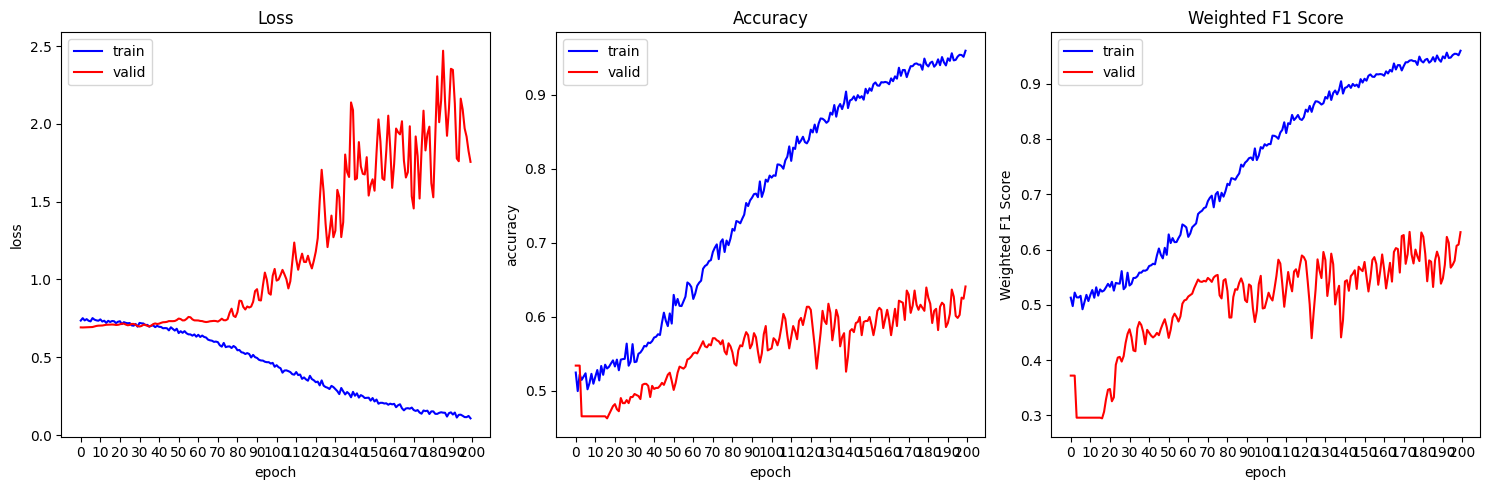

In [33]:
epoch_list = [e for e in range(NUM_EPOCHS)]
train_accuracy_list = [stat["accuracy"] for stat in train_statistics_list]
valid_accuracy_list = [stat["accuracy"] for stat in valid_statistics_list]
train_weighted_f1_score_list = [stat["weighted_f1_score"] for stat in train_statistics_list]
valid_weighted_f1_score_list = [stat["weighted_f1_score"] for stat in valid_statistics_list]


## print trend of statistics during the training process
xticks = [i * 10 for i in range(math.ceil(NUM_EPOCHS / 10) + 1)]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# loss
axes[0].plot(epoch_list, train_loss_list, 'b', label='train')
axes[0].plot(epoch_list, valid_loss_list, 'r', label='valid')
axes[0].set_title("Loss")
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("loss")
axes[0].set_xticks(xticks)
axes[0].legend()

# accuracy
axes[1].plot(epoch_list, train_accuracy_list, 'b', label='train')
axes[1].plot(epoch_list, valid_accuracy_list, 'r', label='valid')
axes[1].set_title("Accuracy")
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("accuracy")
axes[1].set_xticks(xticks)
axes[1].legend()

# weighted f1 score
axes[2].plot(epoch_list, train_weighted_f1_score_list, 'b', label='train')
axes[2].plot(epoch_list, valid_weighted_f1_score_list, 'r', label='valid')
axes[2].set_title("Weighted F1 Score")
axes[2].set_xlabel("epoch")
axes[2].set_ylabel("Weighted F1 Score")
axes[2].set_xticks(xticks)
axes[2].legend()

plt.tight_layout()
plt.show()

In [34]:

print("selected_model_epoch = {}".format(best_epoch))

selected_model_epoch = 199


In [35]:
# load selected model
selected_model_save_name = "model_epoch_{:02d}.pt".format(best_epoch)
selected_model_save_path = os.path.abspath(os.path.join(model_save_root, selected_model_save_name))
model.load_state_dict(torch.load(selected_model_save_path))
print("Selected Model: {}".format(selected_model_save_path))

Selected Model: /content/model/model_epoch_199.pt


正在計算預測信心度...


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38928 (\N{CJK UNIFIED IDEOGRAPH-9810}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20449 (\N{CJK UNIFIED IDEOGRAPH-4FE1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24515 (\N{CJK UNIFIED IDEOGRAPH-5FC3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas

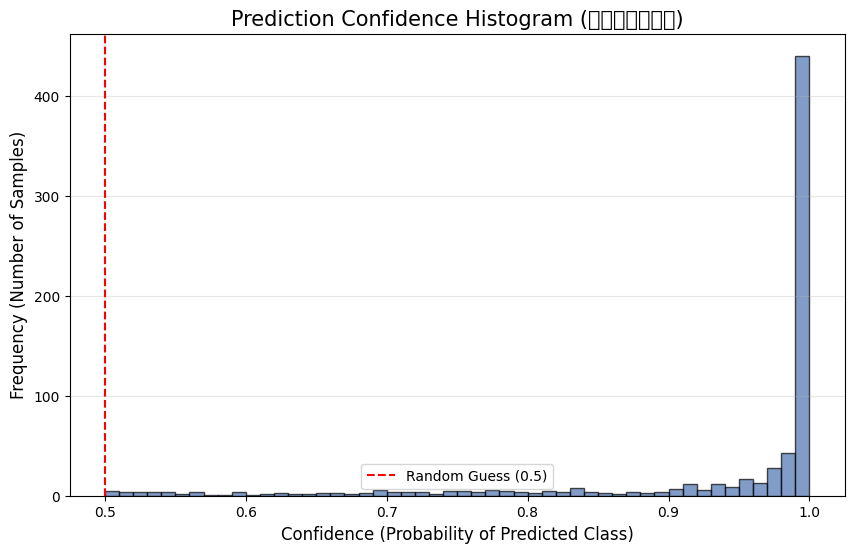

平均信心度: 0.9346


In [36]:
def plot_confidence_histogram(dataloader, device):
    """
    繪製模型預測信心度分佈圖 (Prediction Confidence Histogram)
    """
    model.eval()  # 設定為評估模式
    confidences = []

    print("正在計算預測信心度...")

    with torch.no_grad():
        for data in dataloader:
            # 載入資料
            features = data["features"].to(device).float()

            # 模型推論 (Forward Pass) -> 得到 Logits
            outputs = model(features)

            # 使用 Softmax 將 Logits 轉為機率 (Probabilities)
            probs = F.softmax(outputs, dim=1)

            # 取出每個樣本預測類別的機率值 (即每一列的最大值)
            #這代表模型對該次預測的「信心程度」
            batch_confidences, _ = torch.max(probs, dim=1)

            # 收集結果
            confidences.extend(batch_confidences.cpu().numpy())

    # --- 繪圖 ---
    plt.figure(figsize=(10, 6))

    # 繪製直方圖
    # range=(0.5, 1.0) 是因為二元分類中，勝出類別的機率必然 >= 0.5
    plt.hist(confidences, bins=50, range=(0.5, 1.0), color='#4c72b0', edgecolor='black', alpha=0.7)

    plt.title('Prediction Confidence Histogram (預測信心度分佈)', fontsize=15)
    plt.xlabel('Confidence (Probability of Predicted Class)', fontsize=12)
    plt.ylabel('Frequency (Number of Samples)', fontsize=12)
    plt.axvline(x=0.5, color='r', linestyle='--', label='Random Guess (0.5)')

    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

    print(f"平均信心度: {np.mean(confidences):.4f}")

# 呼叫函式繪製圖表 (使用驗證集 dataloader)
# 確保您的 model 與 valid_dataloader 已經定義好且載入了最佳權重
#print(model)
plot_confidence_histogram(valid_dataloader, DEVICE)

正在計算混淆矩陣數據...


<Figure size 800x600 with 0 Axes>

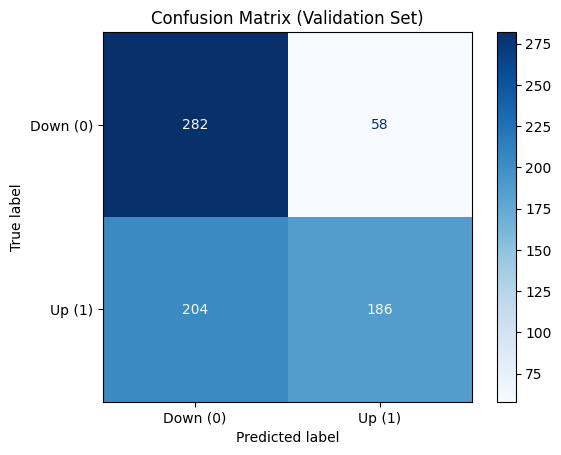

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_confusion_matrix_custom(model, dataloader, device, classes=[0, 1]):
    """
    繪製混淆矩陣 (Confusion Matrix)
    """
    model.eval()  # 設定為評估模式
    all_preds = []
    all_labels = []

    print("正在計算混淆矩陣數據...")

    with torch.no_grad():
        for data in dataloader:
            # 載入資料
            features = data["features"].to(device).float()
            labels = data["label"].to(device).long()

            # 確保標籤是 1D 陣列 (有些 dataloader 可能是 [batch, 1])
            labels = torch.squeeze(labels)

            # 模型推論
            outputs = model(features)

            # 取得預測類別 (Logits 中最大值的索引)
            _, preds = torch.max(outputs, 1)

            # 收集結果
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 計算混淆矩陣
    cm = confusion_matrix(all_labels, all_preds)

    # 繪圖
    plt.figure(figsize=(8, 6))

    # 使用 sklearn 內建的 ConfusionMatrixDisplay 來繪圖
    # display_labels 可以設定為 ['Down', 'Up'] 讓圖表更直觀
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

    # 繪製並設定顏色
    disp.plot(cmap=plt.cm.Blues, values_format='d')

    plt.title('Confusion Matrix (Validation Set)')
    plt.show()

# 定義類別名稱 (假設 0 是跌/持平，1 是漲)
class_names = ['Down (0)', 'Up (1)']

# 呼叫函式繪製
# 確保 model 和 valid_dataloader 已經準備好
plot_confusion_matrix_custom(model, valid_dataloader, DEVICE, classes=class_names)

In [38]:
## show statistics on training/validation dataset for the selected model
print("Statistics for the selected model: ")

# Model Peformance On Training Dataset
train_total_loss, train_statistics, train_y_pred = valid(train_dataloader)
print("Train -> Loss: {:.4f}, Accuracy: {:.4f}, F1 Score: {:.4f}".format(
    train_total_loss/len(train_dataloader),
    train_statistics["accuracy"],
    train_statistics["weighted_f1_score"],
))

# Model Peformance On Valid Dataset
valid_total_loss, valid_statistics, valid_y_pred = valid(valid_dataloader)
print("Valid -> Loss: {:.4f}, Accuracy: {:.4f}, F1 Score: {:.4f}".format(
    valid_total_loss/len(valid_dataloader),
    valid_statistics["accuracy"],
    valid_statistics["weighted_f1_score"],
))

Statistics for the selected model: 
Train -> Loss: 0.1532, Accuracy: 0.9414, F1 Score: 0.9414
Valid -> Loss: 1.7559, Accuracy: 0.6411, F1 Score: 0.6315


In [39]:

def test(dataloader):
    y_prob = []  # 用於收集預測機率

    model.eval()
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            # 載入特徵
            features = data["features"].to(DEVICE).float()

            # 模型推論
            output = model(features)

            # 使用 Softmax 將 logits 轉換為機率分佈
            # dim=1 表示在類別維度上進行 softmax
            probs = torch.nn.functional.softmax(output, dim=1)

            # 取出 Class 1 (預測上漲) 的機率
            # 假設模型輸出 index 1 代表上漲
            prob_class_1 = probs[:, 1].cpu().numpy()

            y_prob.extend(prob_class_1)

    return y_prob

In [40]:
# get your test prediction
test_y_pred = test(test_dataloader)

In [41]:
# create a new dataframe containing your test prediction
# df_test_pred = pd.DataFrame(test_y_pred)

# 1. 執行測試函數取得機率
test_y_prob = test(test_dataloader)

# 2. 建立包含日期與機率的 DataFrame
# df_test 是先前分割出來的測試集 DataFrame，其中包含了 'Date' 欄位
# 注意：請確保 df_test 的索引順序沒有在建立 dataloader 後被更動
result_df = pd.DataFrame({
    'Date': df_test['Date'].values,
    'Probability': test_y_prob
})

# 3. 顯示前幾筆結果確認
display(result_df.head())

# 4. 輸出為 CSV 檔案
# test_prediction_csv_output_path 是您在前面定義的檔案路徑
result_df.to_csv(test_prediction_csv_output_path, index=False)
print(f"預測結果已以機率形式儲存至: {test_prediction_csv_output_path}")

,Date,Probability
0,2025-01-02,0.049174
1,2025-01-03,0.178820
2,2025-01-06,0.000420
3,2025-01-07,0.010036
4,2025-01-08,0.731942


預測結果已以機率形式儲存至: prediction.csv


In [47]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

def evaluate_predictions(truth_file, pred_file, output_file='final_result.csv'):
    # 1. 讀取資料
    df_true = pd.read_csv(truth_file)
    df_pred = pd.read_csv(pred_file)

    # 2. 資料前處理：確保日期格式一致以便合併
    df_true['Date'] = pd.to_datetime(df_true['Date'])
    df_pred['Date'] = pd.to_datetime(df_pred['Date'])

    # 3. 合併資料 (Merge)
    # 使用 inner join 確保只評估兩個檔案中都存在的日期
    merged_df = pd.merge(df_true[['Date', 'Movement']],
                         df_pred[['Date', 'Probability']],
                         on='Date',
                         how='inner')

    # 4. 將預測機率轉為類別 (0 或 1)
    # 假設機率 > 0.5 為上漲 (1)，否則為下跌 (0)
    merged_df['Predicted_Label'] = (merged_df['Probability'] > 0.999).astype(int)

    # === [新增功能] 輸出預測結果至 CSV ===
    # 只選取 'Date' 和 'Predicted_Label' 兩個欄位輸出
    output_df = merged_df[['Date', 'Predicted_Label']]
    output_df.to_csv(output_file, index=False)
    print(f"✅ 已將 0/1 預測結果儲存至: {output_file}")
    print("-" * 30)

    # 定義真實值與預測值以便計算指標
    y_true = merged_df['Movement']
    y_pred = merged_df['Predicted_Label']

    # 5. 計算指標
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='binary')
    cm = confusion_matrix(y_true, y_pred)

    # 6. 按照圖片格式輸出結果
    print("Test Set Evaluation Results")
    print("-" * 30)
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("-" * 30)
    print("Confusion Matrix:")
    print(cm)
    print("-" * 30)

    # 額外顯示詳細報表
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred))

    return merged_df

# === 執行程式 ===
# 請確保檔案名稱與您上傳的一致
file_truth = 'df.csv'         # 真實標籤檔案
file_pred = 'prediction.csv'  # 預測機率檔案
output_csv = 'submission.csv' # 你想要輸出的檔案名稱

# 執行評估並儲存
result_df = evaluate_predictions(file_truth, file_pred, output_csv)

✅ 已將 0/1 預測結果儲存至: submission.csv
------------------------------
Test Set Evaluation Results
------------------------------
Accuracy: 0.5171
F1-Score: 0.3529
------------------------------
Confusion Matrix:
[[79 27]
 [72 27]]
------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.75      0.61       106
           1       0.50      0.27      0.35        99

    accuracy                           0.52       205
   macro avg       0.51      0.51      0.48       205
weighted avg       0.51      0.52      0.49       205

